In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit as skf
from sklearn.preprocessing import MinMaxScaler as mms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import os
from tqdm import tqdm
from time import sleep
import random
import torch.nn.functional as F
from sklearn.metrics import matthews_corrcoef

In [ ]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed()

> SEEDING DONE


In [ ]:
X = pd.read_csv('/content/drive/MyDrive/cs231n/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv')

In [ ]:
drop_list = []
enc_list = []
for f in X.columns:
   if(X[f].nunique() == 1):
    drop_list.append(f)
   elif(X[f].nunique()<11):
     enc_list.append(f)
   else:
     print(f, " " ,X[f].nunique())


    

Dst Port   18567
Timestamp   32043
Flow Duration   389493
Tot Fwd Pkts   751
Tot Bwd Pkts   988
TotLen Fwd Pkts   5842
TotLen Bwd Pkts   15656
Fwd Pkt Len Max   1390
Fwd Pkt Len Min   112
Fwd Pkt Len Mean   17879
Fwd Pkt Len Std   27501
Bwd Pkt Len Max   958
Bwd Pkt Len Min   270
Bwd Pkt Len Mean   24524
Bwd Pkt Len Std   28866
Flow Byts/s   454332
Flow Pkts/s   417167
Flow IAT Mean   418622
Flow IAT Std   416669
Flow IAT Max   295378
Flow IAT Min   66507
Fwd IAT Tot   352376
Fwd IAT Mean   373758
Fwd IAT Std   341531
Fwd IAT Max   303763
Fwd IAT Min   89620
Bwd IAT Tot   293735
Bwd IAT Mean   309260
Bwd IAT Std   330389
Bwd IAT Max   222886
Bwd IAT Min   108796
Fwd Header Len   1237
Bwd Header Len   1843
Fwd Pkts/s   410765
Bwd Pkts/s   359869
Pkt Len Min   80
Pkt Len Max   1139
Pkt Len Mean   36030
Pkt Len Std   42554
Pkt Len Var   42707
Down/Up Ratio   33
Pkt Size Avg   35682
Fwd Seg Size Avg   17879
Bwd Seg Size Avg   24523
Subflow Fwd Pkts   751
Subflow Fwd Byts   5842
Subflow Bwd

In [ ]:
X['Label'].value_counts()

Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64

**Preparing the data and the dataset**

In [ ]:

targets = X['Label']
t_enc = OrdinalEncoder(dtype = np.int64)
targets = t_enc.fit_transform(targets.to_numpy().reshape(-1,1))
enc_list.remove('Label')
f_enc = OrdinalEncoder(dtype = np.float32)
cat_features = X[enc_list]
cat_features = f_enc.fit_transform(cat_features)
ax = X.drop(labels = enc_list + drop_list + ['Timestamp' , 'Dst Port' , 'Label','Flow Byts/s', 'Flow Pkts/s'], axis = 1)
ax = ax.to_numpy()
#mx_c = ax.keys()
splitter = skf(n_splits = 5 , test_size = 0.2 , random_state = 42)


(1048575, 1) int64
['Protocol', 'Fwd PSH Flags', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt', 'Fwd Seg Size Min']
(1048575, 10)


In [ ]:
class iot_data(Dataset):
  def __init__(self,sample , targets = targets):
    self.sample = sample
    self.targets = targets 
  def __len__(self):
    return self.sample.shape[0]
  def __getitem__(self,idx):
    if(idx> self.sample.shape[0]):
      print(idx, self.sample.shape[0])
    o1 = torch.from_numpy(self.sample[idx]).float()
    o2 =torch.from_numpy(self.targets[idx])
    return o1,o2

**Creating the model**

In [ ]:
class encoder(nn.Module):
  def __init__(self,in_features =65 , dim_reduc = 16):
    super(encoder,self).__init__()
    self.l1 = nn.Linear(in_features = in_features,out_features = 256)
    self.relu = nn.ReLU(inplace = True)
    self.l2 = nn.Linear(in_features = 256 , out_features = 256)
    self.l3 = nn.Linear(in_features = 256 , out_features = dim_reduc*4)
    self.l4 = nn.Linear(in_features = dim_reduc*4 , out_features = dim_reduc)
  def forward(self,x):
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu(x)
    x = self.l3(x)
    x = self.relu(x)
    output = self.l4(x)
    return output


In [ ]:
class decoder(nn.Module):
  def __init__(self,in_features = 16 , out_features = 65):
    super(decoder,self).__init__()
    self.l1 = nn.Linear(in_features = in_features , out_features = in_features*4)
    self.relu = nn.ReLU(inplace = True)
    self.l2 = nn.Linear(in_features = in_features*4 , out_features = 256)
    self.l3 = nn.Linear(in_features = 256 , out_features = 256 )
    self.l4 = nn.Linear(in_features = 256 , out_features = 65) 
  def forward(self,x):
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu(x)
    x = self.l3(x)
    x = self.relu(x)
    output = self.l4(x)
    return output


In [ ]:
class aux_classifier(nn.Module):
  def __init__(self,in_features = 16 , num_classes = 3):
    super(aux_classifier,self).__init__()
    self.l1 = nn.Linear(in_features = in_features , out_features = in_features*4)
    self.relu = nn.ReLU(inplace = True)
    self.l2 = nn.Linear(in_features = in_features*4 , out_features = 256)
    self.l3 = nn.Linear(in_features = 256 , out_features = 3)
  def forward(self,x):
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu(x)
    output = self.l3(x)
    return output

In [ ]:
class model_maker(nn.Module):
  def __init__(self,in_features = 65 ,num_classes = 3 ,dim_reduc = 16 ):
    super(model_maker,self).__init__()
    self.enc = encoder(in_features = in_features , dim_reduc = dim_reduc)
    self.ac  = aux_classifier(in_features = dim_reduc , num_classes = num_classes)
    self.dec = decoder(in_features = dim_reduc , out_features = in_features)
  def forward(self,x):
    x = self.enc(x)
    output1 = self.ac(x)
    output2 = self.dec(x)
    return output1,output2,x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if(torch.cuda.is_available()):
  print("The device is " + torch.cuda.get_device_name())
else:
    print("Using cpu no gpu available")
print('\n',device)

Using cpu no gpu available

 cpu


**Classification loss function : Focal Loss**

In [ ]:

class FocalLoss(nn.CrossEntropyLoss):

    def __init__(self, gamma, alpha=None, ignore_index=-100, reduction='mean'):
        super().__init__(weight=alpha, ignore_index=ignore_index, reduction='none')
        self.reduction = reduction
        self.gamma = gamma

    def forward(self, input_, target):
        cross_entropy = super().forward(input_, target)
        target = target * (target != self.ignore_index).long()
        input_prob = torch.gather(F.softmax(input_, 1), 1, target.unsqueeze(1))
        loss = torch.pow(1 - input_prob, self.gamma) * cross_entropy
        return torch.mean(loss)
               

**Creating the training loop.**

In [ ]:

def trainer(targets = targets,ax  = ax):

  H = splitter.split(X = X , y = targets)
  criterion1 = nn.MSELoss()
  criterion2 = FocalLoss(gamma = 2)
  Out_of_fold = 0.0
  print(f"Number of folds to be trained on : {5}")
  for folds,(trainind,testind) in enumerate(H):
    if(folds < 3):
      continue
    best_acc = 0.0 
    print(f"RUNNING FOLD {folds} \n\n")
    scaler = mms()
    ax_copy = ax.copy()
    ax[trainind] = scaler.fit_transform(ax[trainind])
    ax[testind]  = scaler.transform(ax[testind])
    X_train = np.concatenate([ax,cat_features],axis = 1)
    ax = ax_copy
    print(X_train.shape)
    #H = splitter.split(X = ax , y = targets)
    iot_dataset= iot_data(sample = X_train, targets = targets)
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(trainind)
    test_subsampler = torch.utils.data.SubsetRandomSampler(testind)
    trainloader = torch.utils.data.DataLoader(
              iot_dataset, 
              batch_size=512, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      iot_dataset,
                      batch_size=512*64, sampler=test_subsampler)
    print(f"/n/n/n Currently running fold {folds}")
    print("Creating new model instance..")
    model = model_maker()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3,weight_decay = 1e-4)

    model.to(device)
    epochs = 16
    for epoch in range(1,epochs+1):
      model.train()
      scores = []
      targets_x = []
      loss_r = 0.0
      loss_c = 0.0
      i = 0
      print(f"Current epoch : {epoch}")
      with tqdm(trainloader, unit="batch") as tepoch:
        for data,target in tepoch:
          data = data.to(device)
          target = target.to(device)
          target = torch.reshape(target,(target.shape[0],))
          o1,o2,x  = model(data)
    
          #print(o1.shape , target.shape)
          loss_classification = criterion2(o1,target) 
          loss_reconstruction = criterion1(o2,data)
          loss = loss_classification + loss_reconstruction
          targets_x.append(target.detach().cpu().numpy())
          scores.append(o1.detach().cpu().numpy())
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
         
          tepoch.set_postfix(loss_classification=loss_classification.item() , loss_reconstruction = loss_reconstruction.item() , net_loss = loss.item())
          del data,target,o1,o2,x
          sleep(0.1)
      train_acc  = np.mean(np.argmax(np.concatenate(scores,axis = 0),axis = 1) == np.concatenate(targets_x,axis = 0 ))*100
      print(train_acc)
      
      targets_x = []
      scores = []
      with torch.no_grad():
          model.eval()
          with tqdm(testloader,unit = "batch") as tepoch:
            for data,target in tepoch:
              data = data.to(device)
              target = target.to(device)
              target = torch.reshape(target,(target.shape[0],))
              o1,o2,x = model(data)
              loss_classification = criterion2(o1,target) 
              loss_reconstruction = criterion1(o2,data)
              targets_x.append(target.detach().cpu().numpy())
              scores.append(o1.detach().cpu().numpy())
              loss_r+=loss_reconstruction.item()
              loss_c+=loss_classification.item()
              i+=1
              del o1,o2,target,data,x
      loss_r/=i
      loss_c/=i
      #loss_classification_net[folds].append(loss_c)
      #loss_reconstruction_net[folds].append(loss_r)

      test_acc  = np.mean(np.argmax(np.concatenate(scores,axis = 0),axis = 1) == np.concatenate(targets_x,axis = 0 ))*100
      print(f"Test accuracy {test_acc} Test CE loss {loss_c} Test RCN loss {loss_r}")
      if(best_acc<test_acc):
        print(f"New best model found {best_acc}  --->  {test_acc} ")
        best_acc = test_acc
        print("Saving model")
        torch.save(model.state_dict() , 'drive/MyDrive/cs231n/best_model_new_fold_'+str(folds)+'.pth')
    #plt.plot(np.arange(1,21,1),loss_classification_net )
    #plt.show()
    #plt.plot(np.arange(1,21,1),loss_reconstruction_net)
    #plt.show()
    Out_of_fold+=best_acc/5
  print("Out of fold accuracy is " + str(Out_of_fold))



In [ ]:
trainer()

Number of folds to be trained on : 5
RUNNING FOLD 3 


(1048575, 65)
/n/n/n Currently running fold 3
Creating new model instance..
Current epoch : 1


100%|██████████| 1639/1639 [03:40<00:00,  7.45batch/s, loss_classification=2.04e-6, loss_reconstruction=0.00024, net_loss=0.000242]


98.98457430322104


100%|██████████| 7/7 [00:05<00:00,  1.33batch/s]


Test accuracy 99.84884247669457 Test CE loss 1.3455524432564353e-05 Test RCN loss 0.00017810877138150057
New best model found 0.0  --->  99.84884247669457 
Saving model
Current epoch : 2


100%|██████████| 1639/1639 [03:40<00:00,  7.43batch/s, loss_classification=7.7e-8, loss_reconstruction=6.02e-5, net_loss=6.03e-5]


99.88663185752092


100%|██████████| 7/7 [00:05<00:00,  1.31batch/s]


Test accuracy 99.91083136637819 Test CE loss 4.829983725228106e-06 Test RCN loss 8.109995334442439e-05
New best model found 99.84884247669457  --->  99.91083136637819 
Saving model
Current epoch : 3


100%|██████████| 1639/1639 [03:44<00:00,  7.32batch/s, loss_classification=3.28e-5, loss_reconstruction=0.00163, net_loss=0.00166]


99.6565577092721


100%|██████████| 7/7 [00:05<00:00,  1.32batch/s]


Test accuracy 99.65095486731992 Test CE loss 0.00017355140880681574 Test RCN loss 0.0012286945379206113
Current epoch : 4


100%|██████████| 1639/1639 [03:40<00:00,  7.42batch/s, loss_classification=3.24e-7, loss_reconstruction=3.93e-5, net_loss=3.96e-5]


99.7800586510264


100%|██████████| 7/7 [00:05<00:00,  1.28batch/s]


Test accuracy 99.85885606656653 Test CE loss 1.0958763336280494e-05 Test RCN loss 4.8569273141246026e-05
Current epoch : 5


100%|██████████| 1639/1639 [03:40<00:00,  7.42batch/s, loss_classification=2e-7, loss_reconstruction=4.03e-5, net_loss=4.05e-5]


99.89402284052166


100%|██████████| 7/7 [00:05<00:00,  1.33batch/s]


Test accuracy 99.90129461411917 Test CE loss 4.395931715147786e-06 Test RCN loss 6.971106839565826e-05
Current epoch : 6


100%|██████████| 1639/1639 [03:41<00:00,  7.41batch/s, loss_classification=9.84e-9, loss_reconstruction=1.38e-5, net_loss=1.39e-5]


99.92299072550843


100%|██████████| 7/7 [00:05<00:00,  1.29batch/s]


Test accuracy 99.91512290489474 Test CE loss 1.8615941468981743e-06 Test RCN loss 2.424018410757916e-05
New best model found 99.91083136637819  --->  99.91512290489474 
Saving model
Current epoch : 7


100%|██████████| 1639/1639 [03:41<00:00,  7.41batch/s, loss_classification=3.03e-8, loss_reconstruction=1.62e-5, net_loss=1.62e-5]


99.93968004196171


100%|██████████| 7/7 [00:05<00:00,  1.20batch/s]


Test accuracy 99.9728202560618 Test CE loss 1.3771327920559479e-06 Test RCN loss 2.3872505542905336e-05
New best model found 99.91512290489474  --->  99.9728202560618 
Saving model
Current epoch : 8


100%|██████████| 1639/1639 [03:41<00:00,  7.39batch/s, loss_classification=6.87e-8, loss_reconstruction=4.34e-5, net_loss=4.35e-5]


99.90665903726486


100%|██████████| 7/7 [00:06<00:00,  1.12batch/s]


Test accuracy 99.9203681186372 Test CE loss 4.418106527737109e-06 Test RCN loss 0.00010095985843301085
Current epoch : 9


100%|██████████| 1639/1639 [03:41<00:00,  7.39batch/s, loss_classification=1.19e-7, loss_reconstruction=6.89e-5, net_loss=6.9e-5]


99.90689745607133


100%|██████████| 7/7 [00:05<00:00,  1.27batch/s]


Test accuracy 99.91226187921704 Test CE loss 4.525145771237606e-06 Test RCN loss 3.676385313156061e-05
Current epoch : 10


100%|██████████| 1639/1639 [03:41<00:00,  7.41batch/s, loss_classification=3.08e-8, loss_reconstruction=6.55e-6, net_loss=6.58e-6]


99.89545335336051


100%|██████████| 7/7 [00:05<00:00,  1.29batch/s]


Test accuracy 99.86219392985718 Test CE loss 9.535094769879443e-06 Test RCN loss 1.8717411356712027e-05
Current epoch : 11


100%|██████████| 1639/1639 [03:41<00:00,  7.40batch/s, loss_classification=9.22e-8, loss_reconstruction=3.67e-5, net_loss=3.68e-5]


99.90499010561953


100%|██████████| 7/7 [00:05<00:00,  1.26batch/s]


Test accuracy 99.91130820399114 Test CE loss 4.7242022316952766e-06 Test RCN loss 1.9930099369958043e-05
Current epoch : 12


100%|██████████| 1639/1639 [03:41<00:00,  7.39batch/s, loss_classification=2.39e-7, loss_reconstruction=5.57e-6, net_loss=5.81e-6]


99.91524211429798


100%|██████████| 7/7 [00:05<00:00,  1.24batch/s]


Test accuracy 99.91989128102425 Test CE loss 3.2890600972937785e-06 Test RCN loss 1.3970051440992393e-05
Current epoch : 13


100%|██████████| 1639/1639 [03:41<00:00,  7.41batch/s, loss_classification=3.9e-6, loss_reconstruction=5.31e-6, net_loss=9.2e-6]


99.92942803328326


100%|██████████| 7/7 [00:05<00:00,  1.22batch/s]


Test accuracy 99.96471401664164 Test CE loss 1.481538073936203e-06 Test RCN loss 1.293262799403497e-05
Current epoch : 14


100%|██████████| 1639/1639 [03:40<00:00,  7.42batch/s, loss_classification=1.81e-9, loss_reconstruction=2.43e-5, net_loss=2.43e-5]


99.94790549078512


100%|██████████| 7/7 [00:05<00:00,  1.25batch/s]


Test accuracy 99.9194144434113 Test CE loss 2.180506352747865e-06 Test RCN loss 2.4743809262872674e-05
Current epoch : 15


100%|██████████| 1639/1639 [03:41<00:00,  7.39batch/s, loss_classification=1.11e-8, loss_reconstruction=4.84e-6, net_loss=4.85e-6]


99.96030326872184


100%|██████████| 7/7 [00:05<00:00,  1.28batch/s]


Test accuracy 99.97043606799704 Test CE loss 1.1411035854637573e-06 Test RCN loss 9.513830978643714e-06
Current epoch : 16


100%|██████████| 1639/1639 [03:41<00:00,  7.41batch/s, loss_classification=6.98e-8, loss_reconstruction=1.28e-5, net_loss=1.29e-5]


99.95362754214052


100%|██████████| 7/7 [00:05<00:00,  1.26batch/s]


Test accuracy 99.90129461411917 Test CE loss 3.8785962845265336e-06 Test RCN loss 1.5504693172780598e-05
RUNNING FOLD 4 


(1048575, 65)
/n/n/n Currently running fold 4
Creating new model instance..
Current epoch : 1


100%|██████████| 1639/1639 [03:42<00:00,  7.36batch/s, loss_classification=0.000294, loss_reconstruction=0.00172, net_loss=0.00201]


98.5973821615049


100%|██████████| 7/7 [00:05<00:00,  1.34batch/s]


Test accuracy 99.64284862789977 Test CE loss 0.00017141580091057613 Test RCN loss 0.0015422299204926407
New best model found 0.0  --->  99.64284862789977 
Saving model
Current epoch : 2


100%|██████████| 1639/1639 [03:41<00:00,  7.41batch/s, loss_classification=4.01e-5, loss_reconstruction=0.000111, net_loss=0.000151]


99.74489187707127


100%|██████████| 7/7 [00:05<00:00,  1.23batch/s]


Test accuracy 99.83024580978947 Test CE loss 1.849938468824673e-05 Test RCN loss 0.0001175001754225897
New best model found 99.64284862789977  --->  99.83024580978947 
Saving model
Current epoch : 3


100%|██████████| 1639/1639 [03:41<00:00,  7.40batch/s, loss_classification=2.37e-7, loss_reconstruction=2.17e-5, net_loss=2.19e-5]


99.8723267291324


100%|██████████| 7/7 [00:05<00:00,  1.34batch/s]


Test accuracy 99.88985051140834 Test CE loss 8.234160239745897e-06 Test RCN loss 4.897720126401899e-05
New best model found 99.83024580978947  --->  99.88985051140834 
Saving model
Current epoch : 4


100%|██████████| 1639/1639 [03:44<00:00,  7.31batch/s, loss_classification=3.74e-7, loss_reconstruction=3.18e-5, net_loss=3.22e-5]


99.90260591755478


100%|██████████| 7/7 [00:05<00:00,  1.24batch/s]


Test accuracy 99.95517726438261 Test CE loss 2.9238614648160625e-06 Test RCN loss 4.7565319359169477e-05
New best model found 99.88985051140834  --->  99.95517726438261 
Saving model
Current epoch : 5


100%|██████████| 1639/1639 [03:45<00:00,  7.28batch/s, loss_classification=1.05e-7, loss_reconstruction=4.02e-5, net_loss=4.03e-5]


99.93669980688077


100%|██████████| 7/7 [00:06<00:00,  1.11batch/s]


Test accuracy 99.95994564051213 Test CE loss 1.397124086517059e-06 Test RCN loss 5.4737615365801116e-05
New best model found 99.95517726438261  --->  99.95994564051213 
Saving model
Current epoch : 6


100%|██████████| 1639/1639 [03:44<00:00,  7.31batch/s, loss_classification=3.59e-7, loss_reconstruction=2.89e-5, net_loss=2.93e-5]


99.93288510597716


100%|██████████| 7/7 [00:07<00:00,  1.12s/batch]


Test accuracy 99.95136256347901 Test CE loss 1.1718266494296716e-06 Test RCN loss 2.5027877200045623e-05
Current epoch : 7


100%|██████████| 1639/1639 [03:42<00:00,  7.36batch/s, loss_classification=1.88e-5, loss_reconstruction=1.38e-5, net_loss=3.26e-5]


99.9285935674606


100%|██████████| 7/7 [00:05<00:00,  1.28batch/s]


Test accuracy 99.91035452876524 Test CE loss 4.9705183430757775e-06 Test RCN loss 1.967765950082269e-05
Current epoch : 8


100%|██████████| 1639/1639 [03:42<00:00,  7.37batch/s, loss_classification=5.53e-9, loss_reconstruction=1.25e-5, net_loss=1.25e-5]


99.92632858879908


100%|██████████| 7/7 [00:05<00:00,  1.29batch/s]


Test accuracy 99.95660777722146 Test CE loss 1.2567932198440497e-06 Test RCN loss 1.790548438813338e-05
Current epoch : 9


100%|██████████| 1639/1639 [03:42<00:00,  7.37batch/s, loss_classification=7.37e-8, loss_reconstruction=1.8e-5, net_loss=1.8e-5]


99.94111055480056


100%|██████████| 7/7 [00:05<00:00,  1.33batch/s]


Test accuracy 99.97234341844884 Test CE loss 1.6005030667136971e-06 Test RCN loss 1.7647406821197364e-05
New best model found 99.95994564051213  --->  99.97234341844884 
Saving model
Current epoch : 10


100%|██████████| 1639/1639 [03:41<00:00,  7.38batch/s, loss_classification=3.85e-8, loss_reconstruction=4.18e-5, net_loss=4.18e-5]


99.92895119567031


100%|██████████| 7/7 [00:05<00:00,  1.30batch/s]


Test accuracy 99.94134897360703 Test CE loss 3.0847718822509966e-06 Test RCN loss 2.5731001837162433e-05
Current epoch : 11


100%|██████████| 1639/1639 [03:45<00:00,  7.26batch/s, loss_classification=5.48e-6, loss_reconstruction=5.1e-5, net_loss=5.65e-5]


99.93646138807429


100%|██████████| 7/7 [00:05<00:00,  1.27batch/s]


Test accuracy 99.96137615335098 Test CE loss 9.370883325183448e-07 Test RCN loss 1.5764420563105625e-05
Current epoch : 12


100%|██████████| 1639/1639 [03:45<00:00,  7.25batch/s, loss_classification=8.2e-10, loss_reconstruction=1.66e-5, net_loss=1.66e-5]


99.95315070452757


100%|██████████| 7/7 [00:05<00:00,  1.24batch/s]


Test accuracy 99.97091290560999 Test CE loss 6.350857972847734e-07 Test RCN loss 1.2153301733113559e-05
Current epoch : 13


100%|██████████| 1639/1639 [03:46<00:00,  7.23batch/s, loss_classification=7.69e-8, loss_reconstruction=1.02e-5, net_loss=1.03e-5]


99.97067448680352


100%|██████████| 7/7 [00:05<00:00,  1.26batch/s]


Test accuracy 99.9279975204444 Test CE loss 2.4463201790630203e-06 Test RCN loss 1.3787727376828635e-05
Current epoch : 14


100%|██████████| 1639/1639 [03:45<00:00,  7.26batch/s, loss_classification=3.14e-7, loss_reconstruction=6.3e-6, net_loss=6.62e-6]


99.953865960947


100%|██████████| 7/7 [00:05<00:00,  1.32batch/s]


Test accuracy 99.95374675154376 Test CE loss 8.423478448094102e-07 Test RCN loss 8.594036704120559e-06
Current epoch : 15


100%|██████████| 1639/1639 [03:46<00:00,  7.23batch/s, loss_classification=3.07e-7, loss_reconstruction=3.43e-6, net_loss=3.74e-6]


99.97198579023913


100%|██████████| 7/7 [00:05<00:00,  1.31batch/s]


Test accuracy 99.94039529838113 Test CE loss 2.2450157237991723e-06 Test RCN loss 6.3329748627438676e-06
Current epoch : 16


100%|██████████| 1639/1639 [03:45<00:00,  7.27batch/s, loss_classification=3.17e-7, loss_reconstruction=6.85e-6, net_loss=7.17e-6]


99.94599814033332


100%|██████████| 7/7 [00:05<00:00,  1.27batch/s]

Test accuracy 99.98950957251508 Test CE loss 3.731435396860304e-07 Test RCN loss 1.0264509520701332e-05
New best model found 99.97234341844884  --->  99.98950957251508 
Saving model
Out of fold accuracy is 39.99246596571537


**Out of fold predictions:**

In [ ]:
#### out of fold predictions
def predictor(targets = targets , ax = ax):
  H = splitter.split(X = X , y = targets)
  criterion1 = nn.MSELoss()
  criterion2 = FocalLoss(gamma = 2)
  targets_x = []
  scores =  []
  compressed = []
  i = 0
  loss_r = 0.0
  loss_c = 0.0
  for fold,(trainind,testind) in enumerate(H):
    model = model_maker().to(device)
    model.load_state_dict(torch.load(f'/content/drive/MyDrive/cs231n/best_model_new_fold_{fold}.pth',map_location=torch.device(device)))
    scaler = mms()
    ax_copy = ax.copy()
    ax[trainind] = scaler.fit_transform(ax[trainind])
    ax[testind]  = scaler.transform(ax[testind])
    X_train = np.concatenate([ax,cat_features],axis = 1)
    ax = ax_copy
    print(X_train.shape)
    #H = splitter.split(X = ax , y = targets)
    iot_dataset= iot_data(sample = X_train, targets = targets)
    
    
    test_subsampler = torch.utils.data.SubsetRandomSampler(testind)
   
    testloader = torch.utils.data.DataLoader(
                      iot_dataset,
                      batch_size=4096*16, sampler=test_subsampler)
  
    with torch.no_grad():
          model.eval()
          with tqdm(testloader,unit = "batch") as tepoch:
            for data,target in tepoch:
              data = data.to(device)
              target = target.to(device)
              target = torch.reshape(target,(target.shape[0],))
              o1,o2,x = model(data)
              loss_classification = criterion2(o1,target) 
              loss_reconstruction = criterion1(o2,data)
              compressed.append(x.detach().cpu().numpy())
              targets_x.append(target.detach().cpu().numpy())
              scores.append(o1.detach().cpu().numpy())
              loss_r+=loss_reconstruction.item()
              loss_c+=loss_classification.item()
              i+=1
              del o1,o2,target,data,x
  loss_r/=i
  loss_c/=i
  compressed = np.concatenate(compressed,axis = 0)
  targets_x = np.concatenate(targets_x , axis = 0)
  scores = np.argmax(np.concatenate(scores,axis = 0) , axis = 1)
  return loss_r , loss_c ,targets_x , scores , compressed



In [ ]:

l1,l2 , a1 , a2,cm = predictor()

(1048575, 65)


100%|██████████| 4/4 [00:05<00:00,  1.39s/batch]


(1048575, 65)


100%|██████████| 4/4 [00:05<00:00,  1.41s/batch]


(1048575, 65)


100%|██████████| 4/4 [00:08<00:00,  2.20s/batch]


(1048575, 65)


100%|██████████| 4/4 [00:05<00:00,  1.38s/batch]


(1048575, 65)


100%|██████████| 4/4 [00:05<00:00,  1.36s/batch]


In [ ]:
matthews_corrcoef(a1, a2)

0.9994625807064286

In [ ]:
print(l1,l2)

1.7225646661245265e-05 1.1695080431195492e-06


In [ ]:
print(np.mean(a1 == a2)*100)

99.97158047826812


In [ ]:
df = pd.DataFrame(cm)
df.to_csv('/content/drive/MyDrive/cs231n/test_1.csv')

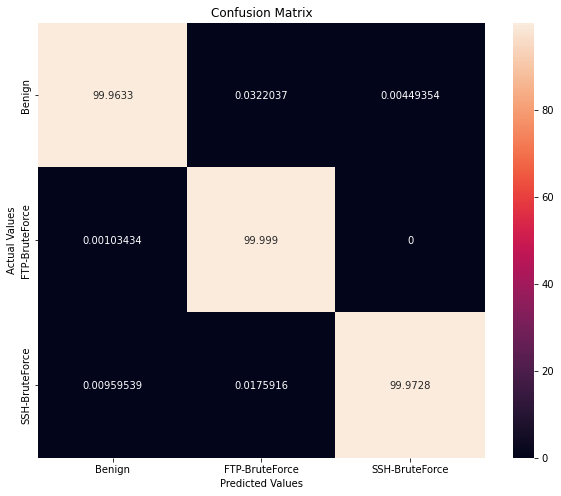

In [ ]:

import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(a1, a2)
cm_df = pd.DataFrame(cm,
                     index = ['Benign','FTP-BruteForce','SSH-BruteForce'], 
                     columns =['Benign','FTP-BruteForce','SSH-BruteForce'])
 
#Plotting the confusion matrix
for i in range(3):
  cm_df.iloc[i]/= np.sum(a1 == i)
  cm_df.iloc[i]*=100.00000
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True ,fmt = '.6g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.savefig("/content/drive/MyDrive/cs231n/confused_2.png")
plt.show()
